# Util module

In [1]:
import sys
import datetime
import math

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
torch.set_default_dtype(torch.float64) 

In [3]:
#from basic_tools import Cell_Dataset,Masked
class Masked_Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, mask):
        #print('aaaa')
        output=input
        ctx.save_for_backward(input, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, mask = ctx.saved_tensors
        grad_input = grad_mask = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mul(mask)

        return grad_input, grad_mask
    
class Masked(nn.Module):    
    def __init__(self, mask):    
        super(Masked, self).__init__()
        
        self.mask = nn.Parameter(torch.Tensor(mask)==1, requires_grad=False)    
        
        
    def forward(self, input):
        return Masked_Function.apply(input, self.mask)

    def extra_repr(self):
        return 'mask={}'.format(self.mask.shape)  

In [4]:
class Poisson_logprob(nn.Module):
    def __init__(self):
        super(Poisson_logprob,self).__init__()
        
    def forward(self,rate,value):
        #rate=rate.clamp(min=1e-3)+(-1)/rate.clamp(max=-1e-5)
        
        return (rate.log() * value) - rate - (value + 1).lgamma()
    
poisson_logprob=Poisson_logprob()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions.negative_binomial import NegativeBinomial
from torch.distributions.normal import Normal
from torch.distributions.dirichlet import Dirichlet


class Poisson_Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Y, X, s, delta_log, beta, mask,to_return='LL'):

        with torch.no_grad():
            #mu=torch.exp((X.matmul(beta)+torch.log(s.view(-1, 1))).unsqueeze(dim=1).repeat(1,delta_log.shape[0],1)+torch.exp(delta_log))
            mu=torch.exp((X.matmul(beta)+torch.log(s.view(-1, 1))).unsqueeze(dim=1).repeat(1,delta_log.shape[0],1)+torch.exp(delta_log)*mask)
            Y_extend=Y.unsqueeze(dim=1).repeat(1,mu.shape[1],1)
            Y_logprob=poisson_logprob(rate=mu,value=Y_extend) # (N,C,G)
            Y_logprob_reduce=Y_logprob.sum(axis=2) # (N,C)
            
            Y_logprob_reduce_reduce=torch.logsumexp(Y_logprob_reduce,dim=1).view(-1,1) # (N,1)
            
            LL=torch.sum(Y_logprob_reduce_reduce) # (1)
            
            gamma=torch.exp(Y_logprob_reduce-Y_logprob_reduce_reduce)
            A=mu-Y.unsqueeze(dim=1)        
            
            #gradient
            grad_delta_log=(A*gamma.unsqueeze(dim=2)).sum(axis=0)
            grad_beta=(X.unsqueeze(dim=2)@gamma.unsqueeze(dim=1)@A).sum(axis=0)
        
            ctx.save_for_backward(grad_delta_log,grad_beta)
            
        if to_return=='LL':
            return LL
        else:
            return gamma
            

    @staticmethod
    def backward(ctx, grad_output):
        
        grad_Y = grad_X = grad_s = grad_delta_log = grad_beta = grad_mask=None
        grad_delta_log,grad_beta = ctx.saved_tensors

        return grad_Y, grad_X, grad_s, grad_delta_log, grad_beta, grad_mask

In [6]:
class Custom_Model_Trick_Hard(nn.Module):
    def __init__(self,Y,rho,X_col=5,delta_min=2,LOWER_BOUND=1e-10,THETA_LOWER_BOUND=1e-20):
        # Y,rho are needed for model parameter initialization
        super(Custom_Model_Trick_Hard, self).__init__()
        
        #rho
        self.masked=Masked(rho)
        self.init_paramter_rho(rho)
        #delta
        self.delta_log_min=np.log(delta_min) #
        self.delta_log=nn.Parameter(torch.Tensor(np.ones(rho.shape)),requires_grad=True) # (C,G)        
        self.init_parameter_delta_min(delta_min)
        #beta
        self.beta=nn.Parameter(torch.Tensor(np.ones((X_col,Y.shape[1]))),requires_grad=True) # (P,G)
        self.init_paramter_Y(Y)
        
    def init_paramter_rho(self,rho):
        self.masked.mask.data=torch.Tensor((rho==1)).to(self.masked.mask.device)
        
    def init_parameter_delta_min(self,delta_min):
        self.delta_log_min=np.log(delta_min) #
        if delta_min==0:
            #self.delta_log.data[:]=torch.Tensor(np.random.uniform(-2,2,size=self.delta_log.data.shape))
            self.delta_log.data=torch.Tensor(np.random.uniform(np.log(2)-0.1,np.log(2)+0.1,size=self.delta_log.shape)).to(self.delta_log.device) # (C,G)
        else:
            self.delta_log.data=torch.Tensor(np.random.uniform(self.delta_log_min-0.1,self.delta_log_min+0.1,size=self.delta_log.shape)).to(self.delta_log.device) # (C,G)
        self.delta_log.data=self.delta_log.data.clamp(min=self.delta_log_min)    

    def init_paramter_Y(self,Y):
        Y_colmean=np.mean(Y,axis=0)
        beta_init=np.hstack([((Y_colmean-Y_colmean.mean())/(np.std(Y_colmean) if len(Y_colmean)>1 else 1)).reshape(-1,1),\
                     np.zeros((Y.shape[1],self.beta.shape[0]-1))]).T      
        self.beta.data[:]=torch.Tensor(beta_init).to(self.beta.device)       
        
    def forward(self,Y,X,s):
        delta_log_masked=self.masked(self.delta_log) #(C,G)
        #delta=torch.exp(delta_log_masked)*self.masked.mask
        
        LL=Poisson_Function.apply(Y,X,s,delta_log_masked,self.beta,self.masked.mask)

        return LL          

In [7]:
class Cell_Dataset(Dataset):
    def __init__(self,Y,X,s):
        self.Y=Y
        self.X=X
        self.s=s
        
    def __len__(self):
        return self.Y.shape[0]
    
    def __getitem__(self,idx):
        item= {"Y":self.Y[idx,:],"X":self.X[idx,:],"s":self.s[idx]}
        return item  

In [8]:
def run_EM_trick(model,optimizer,cell_dataloader,EM_ITER_MAX,M_ITER_MAX,LL_diff_tolerance,Q_diff_tolerance,verbose=True):
    global gamma_new,LL_new
    
    if verbose:
        print('Start time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    with torch.no_grad():
        for batch_idx,batch in enumerate(cell_dataloader):
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)   
        LL_old=model(batch_Y,batch_X,batch_s)
        Q_old=LL_old
    if verbose:
        print(LL_old)

    em_idx_max=0
    m_idx_max=0
    
    for em_idx in range(EM_ITER_MAX):#
        #optimizer = optim.Adam(model.parameters(),lr=0.1,eps=1e-3,betas=(0.9,0.999))
        LL_new=torch.zeros_like(LL_old)
        #optimizer = optim.Adam(model.parameters(),lr=LR)
        for batch_idx,batch in enumerate(cell_dataloader):
            # It is usually just one iteration(batch).
            # However, developer of cellAssign may have done this for extreme situation of larse sample size
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)

            #############
            #M-step
            #############
            for m_idx in range(M_ITER_MAX):#
            #for m_idx in range(20):#    
                optimizer.zero_grad()
                Q_new=-model(batch_Y,batch_X,batch_s)
                Q_new.backward()
                optimizer.step()
                
                #Constraint
                model.delta_log.data=model.delta_log.data.clamp(min=model.delta_log_min)
                #model.NB_basis_a.data=model.NB_basis_a.data.clamp(min=0)

                if m_idx%20==0:
                    #print(sorted(model.delta_log.cpu().detach().numpy().flatten())[-10:])
                    Q_diff=(Q_old-Q_new)/torch.abs(Q_old)
                    Q_old=Q_new
                    if verbose:
                        print('M: {}, Q: {} Q_diff: {}'.format(m_idx,Q_new,Q_diff))    
                    if m_idx>0 and torch.abs(Q_diff)<(Q_diff_tolerance):
                        if verbose:
                            print('M break')
                        break
            m_idx_max=max(m_idx_max,m_idx)
                        
            #############
            #Look at LL
            #############
            with torch.no_grad():
                LL_temp=-Q_new
                LL_new+=LL_temp

        LL_diff=(LL_new-LL_old)/torch.abs(LL_old)
        LL_old=LL_new
        if verbose:
            print('EM: {}, LL: {} LL_diff: {}'.format(em_idx,LL_new,LL_diff))
        if LL_diff<LL_diff_tolerance:
            if verbose:
                print('EM break')
            break
    em_idx_max=max(em_idx_max,em_idx)
    if verbose:
        print('End time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))    
    
    with torch.no_grad():
        gamma_new=Poisson_Function.apply(batch_Y,batch_X,batch_s,model.delta_log,model.beta,model.masked.mask,'gamma')
    return gamma_new,Q_new,LL_new,em_idx_max,m_idx_max

In [9]:
def clustering(Y,num_cluster,EM_ITER_MAX,M_ITER_MAX,verbose=True):

    cell_dataset=Cell_Dataset(Y,X,s)
    cell_dataloader=DataLoader(dataset=cell_dataset,shuffle=False,batch_size=Y.shape[0],num_workers=0)    

    model=Custom_Model_Trick_Hard(Y,np.ones((num_cluster,Y.shape[1])),X_col=X.shape[1],delta_min=0,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)

    # Get threshold

    LL_trial=[]
    for i in range(20):
        model.init_paramter_rho(np.ones((num_cluster,Y.shape[1])))
        model.init_parameter_delta_min(0)
        model.init_paramter_Y(Y)

        optimizer = optim.Adamax(model.parameters(),lr=LR)#,betas=(0.92, 0.999))
        gamma_new,Q_new,LL_new,em_idx_max,m_idx_max=run_EM_trick(model,optimizer,cell_dataloader,
                                            EM_ITER_MAX=1,M_ITER_MAX=40,LL_diff_tolerance=LL_diff_tolerance,Q_diff_tolerance=Q_diff_tolerance,verbose=False)
        LL_trial.append(LL_new.cpu().numpy())    

    LL_trial=np.array(LL_trial)
    LL_trial_threshold=np.max(LL_trial)#np.quantile(LL_trial,q=0.75)
    
    if verbose:
        print(LL_trial,LL_trial_threshold)    


    # Run until it get result above the threshold

    while True:
        model.init_paramter_rho(np.ones((num_cluster,Y.shape[1])))
        model.init_parameter_delta_min(0)
        model.init_paramter_Y(Y)

        optimizer = optim.Adamax(model.parameters(),lr=LR)#,betas=(0.92, 0.999))
        gamma_new,Q_new,LL_new,em_idx_max,m_idx_max=run_EM_trick(model,optimizer,cell_dataloader,
                                            EM_ITER_MAX=EM_ITER_MAX,M_ITER_MAX=M_ITER_MAX,LL_diff_tolerance=LL_diff_tolerance,Q_diff_tolerance=Q_diff_tolerance,verbose=verbose)

        if LL_new.cpu().numpy()>LL_trial_threshold:
            break
            
    return gamma_new,Q_new,LL_new,em_idx_max,m_idx_max

#gamma_new,Q_new,LL_new=clustering(Y=exp_data[0:5].transpose().astype(float),num_cluster=20,verbose=True)

In [11]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'



def clustering_iter(Y,num_cluster,num_marker_list,EM_ITER_MAX,M_ITER_MAX,verbose=True):

    m_idx_max_all=M_ITER_MAX

    gamma_new_list=[]
    LL_new_list=[]

    for num_marker in num_marker_list:
        print('------------------------------------------------')
        print(' markers: {}  threshold {:.3f}'.format(num_marker,marker_criteria.sort_values(ascending=False)[:num_marker].values[-1]))
        print(num_marker)
        #print('criteria > {:.3f}  -> {}'.format(threshold,np.sum(marker_criteria>=threshold)))
        print(m_idx_max_all)

        gamma_new,Q_new,LL_new,em_idx_max,m_idx_max=clustering(Y=exp_data[marker_criteria.sort_values(ascending=False)[:num_marker].index.sort_values()].transpose().astype(float),
                                          num_cluster=3*8,
                                          EM_ITER_MAX=EM_ITER_MAX,
                                          M_ITER_MAX=m_idx_max_all,
                                          verbose=False)

        plot_value=np.argmax(gamma_new.cpu().numpy(),axis=1)

        sns.scatterplot(x="tSNE_1", y="tSNE_2",hue=plot_value,style=np.array((list(range(0,2))*30))[plot_value],
                        data=exp_data_meta,s=40,palette=plt.cm.rainbow)#,linewidth=0.3)
        plt.show()

        #m_idx_max_all.append(m_idx_max)
        m_idx_max_all=int(m_idx_max*0.2+m_idx_max_all*0.8)

        print(em_idx_max,m_idx_max)

        gamma_new_list.append(gamma_new.cpu().numpy())
        LL_new_list.append(LL_new.cpu().numpy())
        """
        gamma_get=gamma_new.cpu().numpy()
        M_true=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,exp_data_meta_clusterid_clusteridunique==i],axis=1) for i in sorted(np.unique(exp_data_meta_clusterid_clusteridunique))])
        M_get=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,np.argmax(gamma_get,axis=1)==i],axis=1) for i in sorted(np.arange(gamma_get.shape[1]))])
        M_get=np.nan_to_num(M_get,nan=0)
        type_mapping=[np.argmin([pearsonr(M_get[i],M_true[j])[1] for j in range(M_true.shape[0])]) for i in range(M_get.shape[0])]
        print('correct',sum(pd.Series(type_mapping)[np.argmax(gamma_get,axis=1)].values==exp_data_meta_clusterid_clusteridunique.values))
        """
    return gamma_new_list,np.array(LL_new_list)
    
def consensus_analysis(gamma_new_list,LL_new_list,num_marker_list):    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()

    ax1.plot(num_marker_list,((np.array(LL_new_list)/Y.shape[0]))/(num_marker_list))
    ax2.plot(num_marker_list,np.array(list(map(lambda x: np.sum(np.unique(np.argmax(x,axis=1),return_counts=True)[1]>10), gamma_new_list))))    
    plot.show()
    
    label_list=np.array(list(map(lambda x: np.argmax(x,axis=1),gamma_new_list)))
    label_list=np.array(list(map(lambda x: [np.unique(x).tolist().index(y) for y in x],label_list)))
    label_df=pd.DataFrame(label_list,index=num_marker_list)    
    
    label_df_true=label_df.copy()
    label_df_true.loc['true']=2*exp_data_meta_clusterid_clusteridunique.values
    label_df_true=label_df_true.iloc[::-1]
    sns.heatmap(label_df.sort_values(num_marker_list[::-1].tolist(),axis=1),cmap=plt.cm.rainbow)    
    plot.show()
    
    #g=sns.clustermap(label_df)
    
    label_df_dup=pd.DataFrame(columns=label_df.columns)
    for idx,row in label_df.iterrows():
        print(row.value_counts())
        for i in range(max(int(100/idx),1)):
            row_name='{}.{}'.format(idx,i)
            label_df_dup.loc[row_name]=row
            label_df_dup.loc[row_name][label_df_dup.loc[row_name]==row.value_counts().index[-1]]=-1

    label_df_dup#.head()    


    #Z = linkage(label_df.T, 'average', metric=lambda x,y: np.sum(x!=y))
    Z = linkage(label_df_dup.T, 'weighted', metric=lambda x,y: np.sum(x!=y))
    #dn = dendrogram(Z,truncate_mode='level',p=2)
    num_cluster_threshold=label_df_dup.max(axis=1).quantile(q=0.1)#;num_cluster_threshold=12

    cluster_consensus=fcluster(Z,t=num_cluster_threshold,criterion='maxclust')#plot_value=list(map(lambda x: np.unique(plot_value).tolist().index(x), plot_value))
    print(num_cluster_threshold,sorted(cluster_consensus))
    print(np.unique(cluster_consensus,return_counts=True))
    
    plot_value=cluster_consensus

    sns.scatterplot(x="tSNE_1", y="tSNE_2",hue=plot_value,style=np.array((list(range(0,2))*30))[plot_value],
                    data=exp_data_meta,s=40,palette=plt.cm.rainbow)#,linewidth=0.3)    
    plot.show()
    
    return cluster_consensus

# (In Separate main module)

In [12]:
from scipy.io import mmread

exp_data=mmread('data/koh_extract/koh.data.counts.mm').toarray().astype(float)
with open('data/koh_extract/koh.data.col','r') as f: exp_data_col=[i.strip().strip('"') for i in f.read().split()]
with open('data/koh_extract/koh.data.row','r') as f: exp_data_row=[i.strip().strip('"') for i in f.read().split()]
assert exp_data.shape==(len(exp_data_row),len(exp_data_col))
assert len(set(exp_data_row))==len(exp_data_row)
assert len(set(exp_data_col))==len(exp_data_col)

In [21]:
exp_data_row[:5],exp_data_col[:5]

(['ENSG00000198804',
  'ENSG00000210082',
  'ENSG00000198712',
  'ENSG00000198938',
  'ENSG00000198727'],
 ['SRR3952323', 'SRR3952325', 'SRR3952326', 'SRR3952327', 'SRR3952328'])

## cluster info 

In [16]:
exp_data_meta=pd.read_csv('data/koh_extract/koh.metadata.tsv',sep='\t')
exp_data_meta.head()

,Run,LibraryName,phenoid,libsize.drop,feature.drop,total_features,log10_total_features,total_counts,log10_total_counts,pct_counts_top_50_features,pct_counts_top_100_features,pct_counts_top_200_features,pct_counts_top_500_features,is_cell_control,celltype,tSNE_1,tSNE_2
SRR3952323,SRR3952323,H7hESC,H7hESC,False,False,4895,3.689841,2.248411e+06,6.351876,18.278965,25.975390,35.537616,52.410941,False,hESC,9.973465,19.045918
SRR3952325,SRR3952325,H7hESC,H7hESC,False,False,4887,3.689131,2.271617e+06,6.356335,24.672529,32.222803,41.547358,57.969233,False,hESC,10.366232,21.511833
SRR3952326,SRR3952326,H7hESC,H7hESC,False,False,4888,3.689220,5.846824e+05,5.766921,22.732839,30.205988,39.431308,55.285817,False,hESC,9.881356,19.317197
SRR3952327,SRR3952327,H7hESC,H7hESC,False,False,4879,3.688420,3.191810e+06,6.504037,20.867378,29.003904,38.785558,56.020859,False,hESC,8.483966,21.289459
SRR3952328,SRR3952328,H7hESC,H7hESC,False,False,4873,3.687886,2.190385e+06,6.340521,21.287923,29.423689,39.307683,56.640975,False,hESC,9.017168,20.637262


In [17]:
clustername_unique=list(clustername_to_markers.index)
exp_data_meta_clusterid_clusteridunique=exp_data_meta['celltype'].apply(lambda x: clustername_unique.index(x))

In [18]:
marker_unique=list(clustername_to_markers.columns)
marker_unique_exp_data_idx=[exp_data_row.index(marker) for marker in marker_unique]

In [19]:
pi_true=np.array([np.sum(exp_data_meta_clusterid_clusteridunique==i) for i in sorted(np.unique(exp_data_meta_clusterid_clusteridunique))])/exp_data_meta_clusterid_clusteridunique.shape[0]
M_true=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,exp_data_meta_clusterid_clusteridunique==i],axis=1) for i in sorted(np.unique(exp_data_meta_clusterid_clusteridunique))])

In [20]:
cell_size_factor=pd.read_csv('data/analysis/koh.size_factor_cluster.tsv',sep='\t',header=None)[0].values.astype(float)#.reshape(-1,1)
#cell_size_factor=np.ones_like(cell_size_factor)
cell_size_factor.shape

(446,)

In [21]:
Y=exp_data[marker_unique_exp_data_idx].transpose().astype(float)
Y.shape

(446, 84)

In [22]:
#marker_onehot=np.array([np.sum(np.eye(len(marker_unique))[[marker_unique.tolist().index(marker) for marker in value]],axis=0) for key,value in clustername_to_markers.items()])
#marker_onehot.shape
#marker_onehot.T
marker_onehot=clustername_to_markers

In [23]:
#exp_data_col_patient=pd.Series(exp_data_col).str.slice(start=1,stop=2).astype(int).values
#x_data_covariate=np.eye(len(np.unique(exp_data_col_patient)))[exp_data_col_patient-1]
x_data_intercept=np.array([np.ones(Y.shape[0])]).transpose()
x_data_null=np.concatenate([x_data_intercept],axis=1)
x_data_null.shape

(446, 1)

In [24]:
Y
s=cell_size_factor
#X=x_data_null.copy()[:,[0, 1,2,3,4]]
#X=x_data_null.copy()[:,[0, 1,2]]
#X=x_data_null.copy()[:,[0,1,2,3]]
X=x_data_null.copy()#[:,[0,1,2]]
# 234 x
# 34 x
# 123 x
rho=marker_onehot

LR=1e-1


EM_ITER_MAX=20
M_ITER_MAX=10000

device='cuda:1'


LL_df=pd.read_csv('QQ_ratio.tsv',sep='\t',index_col=0)
"""
Seurat_df=pd.concat([pd.read_csv('koh_vst.tsv',header=None),
                     pd.read_csv('koh_norm_vst.tsv',header=None),
                     pd.read_csv('koh_norm_mvp.tsv',header=None),
                     pd.read_csv('koh_norm_disp.tsv',header=None)],axis=1)
Seurat_df.columns=['vst','norm_vst','norm_mvp','norm_disp']

Seurat_df_idxmatch=pd.DataFrame([list(map(lambda x: np.where(Seurat_df['vst'].values==x)[0][0] if x in Seurat_df['vst'].values else np.nan, exp_data_row)),
                        list(map(lambda x: np.where(Seurat_df['norm_vst'].values==x)[0][0] if x in Seurat_df['norm_vst'].values else np.nan, exp_data_row)),
                        list(map(lambda x: np.where(Seurat_df['norm_mvp'].values==x)[0][0] if x in Seurat_df['norm_mvp'].values else np.nan, exp_data_row)),
                        list(map(lambda x: np.where(Seurat_df['norm_disp'].values==x)[0][0] if x in Seurat_df['norm_disp'].values else np.nan, exp_data_row))
                       ],
                       index=['vst','norm_vst','norm_mvp','norm_disp']).T

Seurat_df_idxmatch=Seurat_df_idxmatch.apply(lambda x : x.fillna((~x.isnull()).sum()))
Seurat_df_idxmatch=Seurat_df_idxmatch.max(axis=0)-Seurat_df_idxmatch
"""
marker_criteria=LL_df['QQratio2']#.sort_values(ascending=False)

In [37]:
gamma_new_list,LL_new_list=clustering_iter(Y,num_cluster,num_marker_list,EM_ITER_MAX,M_ITER_MAX,verbose=True):
    consensus_analysis(gamma_new_list,LL_new_list,num_marker_list):    

In [40]:
M_ITER_MAX

10000

In [41]:
"""
gamma_new,Q_new,LL_new,em_idx_max,m_idx_max=clustering(Y=exp_data[marker_unique_exp_data_idx].transpose().astype(float),
                                  num_cluster=3*8,
                                  EM_ITER_MAX=EM_ITER_MAX,
                                  M_ITER_MAX=M_ITER_MAX,
                                  verbose=False)



import seaborn as sns

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'


plot_value=np.argmax(gamma_new.cpu().numpy(),axis=1)

sns.scatterplot(x="tSNE_1", y="tSNE_2",hue=plot_value,style=np.array((list(range(0,2))*30))[plot_value],
                data=exp_data_meta,s=40,palette=plt.cm.rainbow)#,linewidth=0.3)
plt.show()


from scipy.stats import pearsonr

gamma_get=gamma_new.cpu().numpy()
M_true=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,exp_data_meta_clusterid_clusteridunique==i],axis=1) for i in sorted(np.unique(exp_data_meta_clusterid_clusteridunique))])
M_get=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,np.argmax(gamma_get,axis=1)==i],axis=1) for i in sorted(np.arange(gamma_get.shape[1]))])
M_get=np.nan_to_num(M_get,nan=0)
type_mapping=[np.argmin([pearsonr(M_get[i],M_true[j])[1] for j in range(M_true.shape[0])]) for i in range(M_get.shape[0])]
sum(pd.Series(type_mapping)[np.argmax(gamma_get,axis=1)].values==exp_data_meta_clusterid_clusteridunique.values)
"""

'\ngamma_new,Q_new,LL_new,em_idx_max,m_idx_max=clustering(Y=exp_data[marker_unique_exp_data_idx].transpose().astype(float),\n                                  num_cluster=3*8,\n                                  EM_ITER_MAX=EM_ITER_MAX,\n                                  M_ITER_MAX=M_ITER_MAX,\n                                  verbose=False)\n\n\n\nimport seaborn as sns\n\nplt.rcParams["figure.figsize"] = (15,15)\nplt.rcParams["font.size"] = 15\nplt.rcParams[\'font.family\']=\'Arial\'\n\n\nplot_value=np.argmax(gamma_new.cpu().numpy(),axis=1)\n\nsns.scatterplot(x="tSNE_1", y="tSNE_2",hue=plot_value,style=np.array((list(range(0,2))*30))[plot_value],\n                data=exp_data_meta,s=40,palette=plt.cm.rainbow)#,linewidth=0.3)\nplt.show()\n\n\nfrom scipy.stats import pearsonr\n\ngamma_get=gamma_new.cpu().numpy()\nM_true=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,exp_data_meta_clusterid_clusteridunique==i],axis=1) for i in sorted(np.unique(exp_data_meta_clusterid_cluster

In [44]:
import seaborn as sns

label_list=np.array(list(map(lambda x: np.argmax(x,axis=1),gamma_new_list)))
label_list=np.array(list(map(lambda x: [np.unique(x).tolist().index(y) for y in x],label_list)))
label_df=pd.DataFrame(label_list,index=num_marker_list)

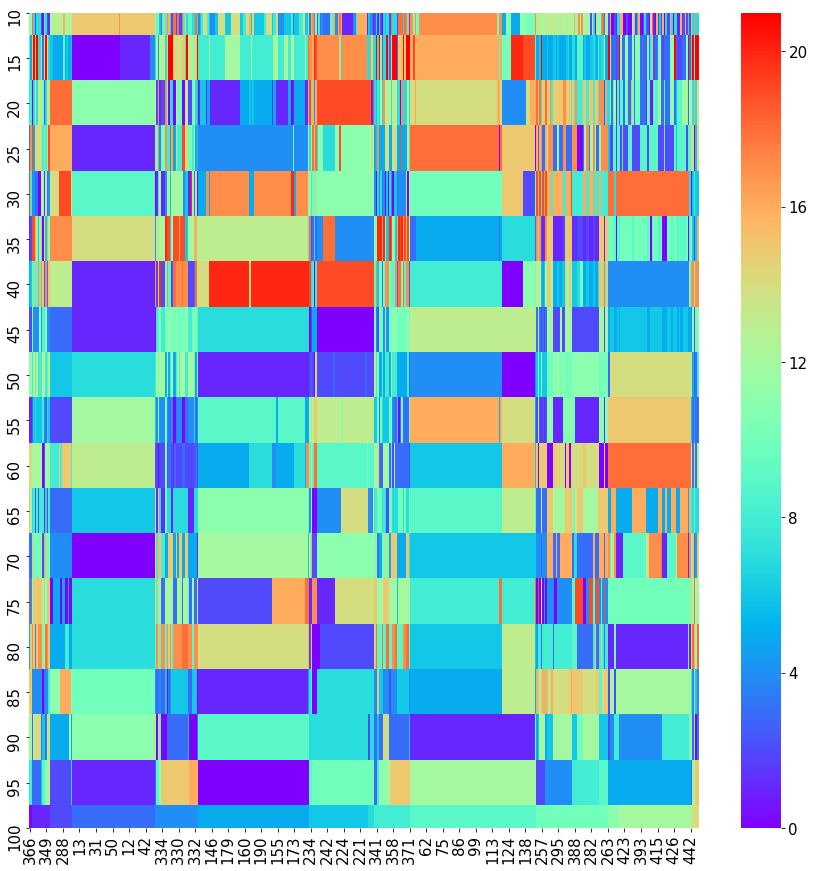

In [45]:
label_df_true=label_df.copy()
label_df_true.loc['true']=2*exp_data_meta_clusterid_clusteridunique.values
label_df_true=label_df_true.iloc[::-1]
sns.heatmap(label_df.sort_values(num_marker_list[::-1].tolist(),axis=1),cmap=plt.cm.rainbow)

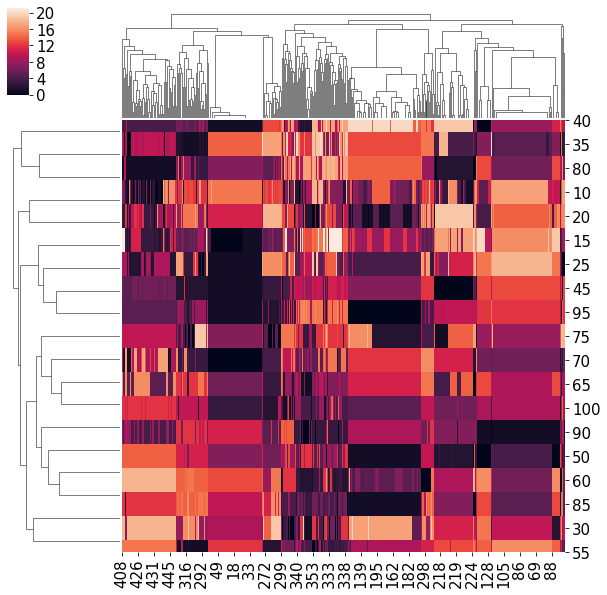

In [46]:
g=sns.clustermap(label_df)

In [82]:
row.value_counts()#.index[-1]
(label_df_dup==-1).sum().sum(),label_df.shape,label_df_dup.shape

(160, (19, 446), (46, 446))

In [81]:
label_df_dup=pd.DataFrame(columns=label_df.columns)
for idx,row in label_df.iterrows():
    print(row.value_counts())
    for i in range(max(int(100/idx),1)):
        row_name='{}.{}'.format(idx,i)
        label_df_dup.loc[row_name]=row
        label_df_dup.loc[row_name][label_df_dup.loc[row_name]==row.value_counts().index[-1]]=-1

label_df_dup#.head()

17    63
15    54
6     34
7     34
12    31
16    27
13    27
2     27
14    26
0     16
1     15
4     15
18    14
8     14
3     12
10    11
5     10
9      9
11     7
Name: 10, dtype: int64
16    60
8     54
5     36
17    34
0     32
3     31
21    26
12    22
7     21
1     20
11    15
6     15
14    13
15    11
13    10
9     10
19    10
20     9
2      7
10     6
4      3
18     1
Name: 15, dtype: int64
14    61
11    55
1     39
19    38
5     32
15    23
13    20
7     19
18    18
3     17
4     17
8     17
10    16
9     12
16    12
17    12
12    11
6      9
2      9
0      9
Name: 20, dtype: int64
4     73
18    62
1     55
9     29
11    27
2     24
15    23
14    22
17    21
16    18
3     18
5     16
8     10
7     10
10     9
19     8
12     8
0      7
6      5
13     1
Name: 25, dtype: int64
10    64
17    61
9     55
18    53
11    39
8     25
16    22
12    18
15    15
4     14
19    14
5     10
0     10
6      9
2      8
14     7
1      7
3      6
7      5
20     3

,0,1,2,3,4,5,6,7,8,9,...,436,437,438,439,440,441,442,443,444,445
10.0,15,17,15,15,15,15,15,15,15,15,...,1,0,7,14,0,16,2,0,7,16
10.1,15,17,15,15,15,15,15,15,15,15,...,1,0,7,14,0,16,2,0,7,16
10.2,15,17,15,15,15,15,15,15,15,15,...,1,0,7,14,0,16,2,0,7,16
10.3,15,17,15,15,15,15,15,15,15,15,...,1,0,7,14,0,16,2,0,7,16
10.4,15,17,15,15,15,15,15,15,15,15,...,1,0,7,14,0,16,2,0,7,16
10.5,15,17,15,15,15,15,15,15,15,15,...,1,0,7,14,0,16,2,0,7,16
10.6,15,17,15,15,15,15,15,15,15,15,...,1,0,7,14,0,16,2,0,7,16
10.7,15,17,15,15,15,15,15,15,15,15,...,1,0,7,14,0,16,2,0,7,16
10.8,15,17,15,15,15,15,15,15,15,15,...,1,0,7,14,0,16,2,0,7,16
10.9,15,17,15,15,15,15,15,15,15,15,...,1,0,7,14,0,16,2,0,7,16


In [107]:
#Z = linkage(label_df.T, 'average', metric=lambda x,y: np.sum(x!=y))
Z = linkage(label_df_dup.T, 'weighted', metric=lambda x,y: np.sum(x!=y))
#dn = dendrogram(Z,truncate_mode='level',p=2)
num_cluster_threshold=label_df_dup.max(axis=1).quantile(q=0.1)#;num_cluster_threshold=12

cluster_consensus=fcluster(Z,t=num_cluster_threshold,criterion='maxclust')#plot_value=list(map(lambda x: np.unique(plot_value).tolist().index(x), plot_value))
print(num_cluster_threshold,sorted(cluster_consensus))

14.0 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,

In [108]:
np.unique(cluster_consensus,return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int32),
 array([18, 24, 26, 39,  9, 74, 54,  6, 11,  7, 35, 55, 23, 65]))

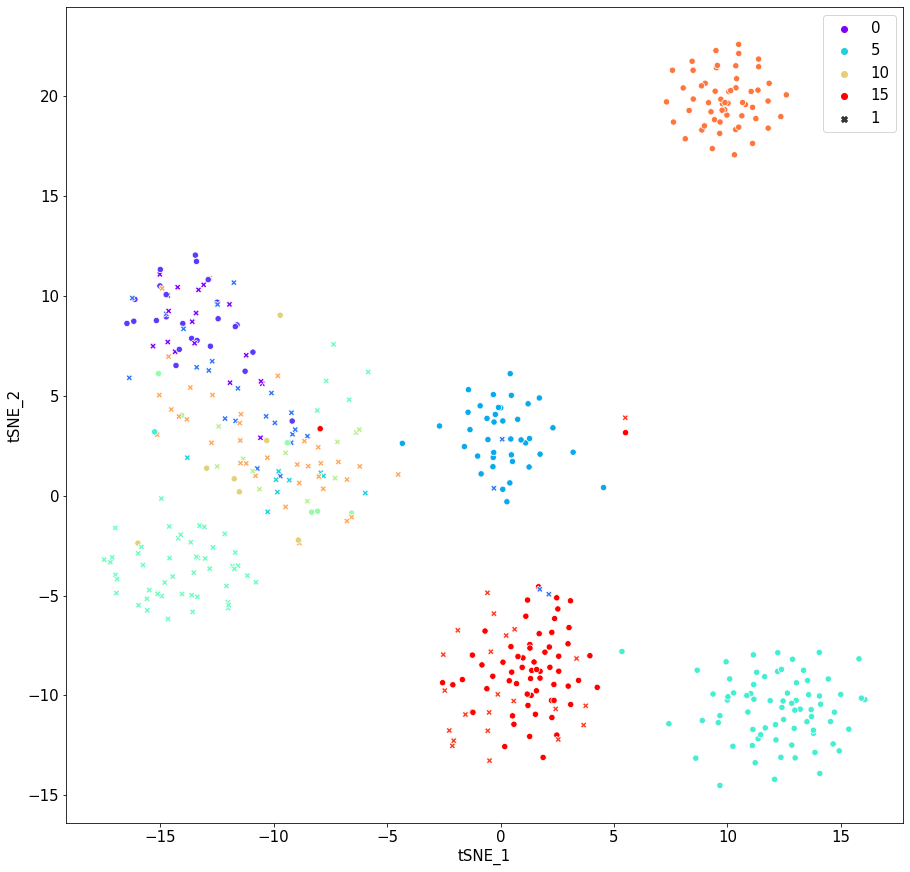

In [109]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'


plot_value=cluster_consensus

sns.scatterplot(x="tSNE_1", y="tSNE_2",hue=plot_value,style=np.array((list(range(0,2))*30))[plot_value],
                data=exp_data_meta,s=40,palette=plt.cm.rainbow)#,linewidth=0.3)

In [110]:
from scipy.stats import pearsonr

gamma_get=np.eye(len(np.unique(cluster_consensus)))[cluster_consensus-1]
M_true=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,exp_data_meta_clusterid_clusteridunique==i],axis=1) for i in sorted(np.unique(exp_data_meta_clusterid_clusteridunique))])
M_get=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,np.argmax(gamma_get,axis=1)==i],axis=1) for i in sorted(np.arange(gamma_get.shape[1]))])
M_get=np.nan_to_num(M_get,nan=0)
type_mapping=[np.argmin([pearsonr(M_get[i],M_true[j])[1] for j in range(M_true.shape[0])]) for i in range(M_get.shape[0])]
sum(pd.Series(type_mapping)[np.argmax(gamma_get,axis=1)].values==exp_data_meta_clusterid_clusteridunique.values)

432